In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

In [2]:
def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C

def dpsidt(t,psi, H):
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H)
    return -1*np.matmul(A,psi)

def rungeKutta(psi0, h, H, t = 2, t0 = 0, p = 0):
    
    n = (int)((t-t0))
    S = np.zeros((2,int(t)), dtype=np.complex_)
    r = 0
    
    for i in range(1 + p, n + 1 + p):
        
        S[0][r] = psi0[0][0]
        S[1][r] = psi0[1][0]
        
        k1 = dpsidt(t0, psi0, H)
        k2 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k1)), H)
        k3 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k2)), H)
        k4 = dpsidt(t0 + h, somar(psi0, np.dot(h, k3)), H)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        psi0 = somar(psi0,np.dot((h / 6.0),(C)))
    
        t0 = t0 + h
        
        r = r + 1
        
    return S

def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    #H2 = np.zeros((2,2), dtype=np.complex_)
    
    H1 = [[0, x[0]], [x[0], 0]] #-5, -5
    #H2 = [[0, x[1]], [x[1], 0]]
    
    M = np.zeros((2,1),dtype=np.complex_)
    N = np.zeros((2,1),dtype=np.complex_)
    O = np.zeros((2,1),dtype=np.complex_)
    P = np.zeros((2,1),dtype=np.complex_)
    
    Result1 = np.zeros((2,1),dtype=np.complex_)
    Result2 = np.zeros((2,1),dtype=np.complex_)
    Result3 = np.zeros((2,1),dtype=np.complex_)
    Result4 = np.zeros((2,1),dtype=np.complex_)
    
    
    M = psi0
    
    Result2 = rungeKutta(M, h, somar(H,H1), t = 2, t0 = 0, p = 0)
    N = [[Result2[0][1]],[Result2[1][1]]]
    
    H1 = [[0, x[1]], [x[1], 0]]
    Result3 = rungeKutta(M, h, somar(H,H1), t = 3, t0 = 0, p = 0)
    O = [[Result3[0][2]],[Result3[1][2]]]
    
    H1 = [[0, x[2]], [x[2], 0]]
    Result4 = rungeKutta(M, h, somar(H,H1), t = 4, t0 = 0, p = 0)
    O = [[Result4[0][3]],[Result4[1][3]]]
    
    
    Z = np.zeros((2,1),dtype=np.complex_)
    Y = np.zeros((2,1),dtype=np.complex_)
    W = np.zeros((2,1),dtype=np.complex_)
    X = np.zeros((2,1),dtype=np.complex_)
    
    Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100)
    
    Y[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(i+1)/100)
    Y[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(i+1)/100)
    
    W[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(i+2)/100)
    W[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(i+2)/100)

    X[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*(i+3)/100)
    X[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*(i+3)/100)
    
    return (np.linalg.norm(Z-M)**2+np.linalg.norm(Y-N)**2+np.linalg.norm(W-O)**2+np.linalg.norm(X-P)**2)

In [3]:
x = []
x.append(random.uniform(-5, 5))
a=x[0]
x.append(x[0])
x.append(x[0])

i = 0

psi0 = [[complex(1.0,0)],[complex(0.0,0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]
h = 0.01

E = np.zeros((2,2))
I = np.zeros((2,2))
R = np.zeros((2,2), dtype=np.complex_)
H = E.astype(complex)

A = (1/2*np.pi)
B = (3/2*np.pi)

I = [[1, 0], [0, 1]]
H = [[A, 0], [0, B]]
R = H

D = np.zeros((2,1), dtype=np.complex_)
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp = np.zeros((2,1000), dtype=np.complex_)

while i < 1000:
    
    print("iteracao: ", (i+1))
    
    Resp[0][i] = psi0[0][0]
    Resp[1][i] = psi0[1][0]

    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='BFGS')
    
    x = []
    u = np.zeros((2,1))
    x.append(random.uniform(-5, 5))
    a=x[0]
    x.append(x[0])
    x.append(x[0])
    
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
        
    i = i + 1
    H = somar(H, u)
    
    psi_t = np.zeros((2,2), dtype=np.complex_)
    
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0, p = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    print(psi0)

iteracao:  1
[[(0.9997590708054921-0.015704238346461112j)], [(-0.00048169934958226823-0.015327920934985891j)]]
iteracao:  2
[[(0.9983987236372928-0.03135411336414609j)], [(-0.002698810119706598-0.047006640465206924j)]]
iteracao:  3
[[(0.9958264804026412-0.046873596643567154j)], [(-0.006870460853832425-0.0780082233763391j)]]
iteracao:  4
[[(0.9920685942598225-0.062184562585516114j)], [(-0.01296242122192759-0.10846639596226386j)]]
iteracao:  5
[[(0.987096949143681-0.07720334398021443j)], [(-0.020974504778722713-0.13870589549680154j)]]
iteracao:  6
[[(0.9809449513765799-0.0918526775140296j)], [(-0.030868519616820748-0.1683960236862237j)]]
iteracao:  7
[[(0.9738662359391839-0.10610123268449496j)], [(-0.04246224699525149-0.19627541490991016j)]]
iteracao:  8
[[(0.9656826754870143-0.11984069101107557j)], [(-0.05580680301791513-0.2235638107400044j)]]
iteracao:  9
[[(0.9565122391261118-0.13302211949676215j)], [(-0.07080089737509303-0.24975324312620986j)]]
iteracao:  10
[[(0.9464009314034324-0.1

[[(0.5526705921466093-0.2866405332526831j)], [(-0.1486871168183813+0.7682997792770765j)]]
iteracao:  81
[[(0.5523373596483527-0.29459755278809474j)], [(-0.11399812422048453+0.7714532642276773j)]]
iteracao:  82
[[(0.5509977667641783-0.3028448120808476j)], [(-0.07888316391783795+0.7736044954405944j)]]
iteracao:  83
[[(0.5501251964810071-0.3111796067019728j)], [(-0.043986543857557445+0.7736890153940447j)]]
iteracao:  84
[[(0.5488377972428218-0.3196852867202352j)], [(-0.00904895510094774+0.7723318549107151j)]]
iteracao:  85
[[(0.5469738382978604-0.32832733322684265j)], [(0.025934204535480676+0.7696415966855984j)]]
iteracao:  86
[[(0.5450380044043424-0.33708989741074447j)], [(0.06067977128451059+0.7652593860443344j)]]
iteracao:  87
[[(0.5427906406747964-0.345952672214115j)], [(0.09521294856413377+0.7593612783628584j)]]
iteracao:  88
[[(0.5402861469555771-0.35490534198164314j)], [(0.12943696253846843+0.7519169754373852j)]]
iteracao:  89
[[(0.5375563354879875-0.36394192913663603j)], [(0.16326

[[(-0.09660111846660428-0.7064001358520882j)], [(-0.2442555748513566-0.6572718372345643j)]]
iteracao:  159
[[(-0.10809907288300032-0.7046265687675757j)], [(-0.2753946403078351-0.644960280117233j)]]
iteracao:  160
[[(-0.11973542452037957-0.7025709951408442j)], [(-0.30611190599190796-0.6311520479589756j)]]
iteracao:  161
[[(-0.13060548624702414-0.7006825919775221j)], [(-0.3353340043168221-0.6160659051334912j)]]
iteracao:  162
[[(-0.14201774326796918-0.6982969983233108j)], [(-0.36446843225220954-0.5994789455855244j)]]
iteracao:  163
[[(-0.15334865642522374-0.6957322211995977j)], [(-0.39275155868466016-0.5815385289118791j)]]
iteracao:  164
[[(-0.16415423995487619-0.6933124816139045j)], [(-0.41958403119554116-0.5624236930781814j)]]
iteracao:  165
[[(-0.17527947338405375-0.6904451029835433j)], [(-0.44593200451598153-0.5419476862892801j)]]
iteracao:  166
[[(-0.18620154640277428-0.6875202239225103j)], [(-0.47109418751448934-0.5203029632614855j)]]
iteracao:  167
[[(-0.19713657238434057-0.684357

[[(-0.6964264026835659-0.12109947522527212j)], [(0.5915066725146781+0.38787242092875535j)]]
iteracao:  239
[[(-0.6982770113297814-0.11008934062263127j)], [(0.60913055259563+0.35951286228547946j)]]
iteracao:  240
[[(-0.699919071228591-0.0991095299604035j)], [(0.6253894558539648+0.3304218499987372j)]]
iteracao:  241
[[(-0.7013413144862787-0.08820194854891862j)], [(0.6402482408045672+0.30070407810068706j)]]
iteracao:  242
[[(-0.7026178991581981-0.07722652745488115j)], [(0.6536973245781661+0.2702664140736035j)]]
iteracao:  243
[[(-0.7038415895404013-0.06592247080488468j)], [(0.6657243885535464+0.23889800874067257j)]]
iteracao:  244
[[(-0.7047325699844501-0.0550368628487952j)], [(0.6762273837183459+0.20745951263895854j)]]
iteracao:  245
[[(-0.7054768809998355-0.04408241119335885j)], [(0.6852434895220404+0.17550056049628898j)]]
iteracao:  246
[[(-0.7060961970276716-0.03293330303437188j)], [(0.6927519721500319+0.14296236696648634j)]]
iteracao:  247
[[(-0.7065099556242752-0.02193282775572868j)

[[(-0.35036031368073683+0.613744621509836j)], [(-0.7067150044062281-0.033452392672481214j)]]
iteracao:  317
[[(-0.3406845099403789+0.619661803017591j)], [(-0.7070737397114392+0.00010470621798167046j)]]
iteracao:  318
[[(-0.3309119276125184+0.6248519045884194j)], [(-0.7063593627232962+0.03337385051986501j)]]
iteracao:  319
[[(-0.32105328141769535+0.6300115805765389j)], [(-0.7039679424921522+0.06662810523241683j)]]
iteracao:  320
[[(-0.3111106387842538+0.6350340155457735j)], [(-0.6999956007989564+0.09974015216521886j)]]
iteracao:  321
[[(-0.30115677696225446+0.639503235507457j)], [(-0.6948337798972444+0.1324620521538411j)]]
iteracao:  322
[[(-0.29097745198783354+0.6445898236739648j)], [(-0.6874135085702106+0.16522324076723854j)]]
iteracao:  323
[[(-0.28084847843254934+0.648964994825748j)], [(-0.6789782426077388+0.1973754874507844j)]]
iteracao:  324
[[(-0.2706178180068258+0.6533040421530649j)], [(-0.6689192733517938+0.2291436232458304j)]]
iteracao:  325
[[(-0.2603822149520127+0.6573168716

[[(0.47575851373444283+0.5228496610737363j)], [(0.5911026717073505-0.38843231558979774j)]]
iteracao:  397
[[(0.4840156437355692+0.5154591396859796j)], [(0.5720199153359077-0.41572095459127256j)]]
iteracao:  398
[[(0.49208713061440734+0.507837707514537j)], [(0.551761714267441-0.44216523268611974j)]]
iteracao:  399
[[(0.5000055047748784+0.5000483964208695j)], [(0.5303178766682756-0.4676633507763076j)]]
iteracao:  400
[[(0.5078598200395276+0.4921985215636376j)], [(0.5076376079318197-0.4920599973973655j)]]
iteracao:  401
[[(0.5155285097976731+0.48416090271414786j)], [(0.48389465691194283-0.5154265226685849j)]]
iteracao:  402
[[(0.5227755315135064+0.47574425439543633j)], [(0.4593369109360175-0.5379430393874481j)]]
iteracao:  403
[[(0.5303215458004878+0.4675845662375048j)], [(0.4333717570459393-0.5588493669210726j)]]
iteracao:  404
[[(0.5377280606769813+0.4592895166424901j)], [(0.4064648490111826-0.5785222228591286j)]]
iteracao:  405
[[(0.5448647161897988+0.45077922708812357j)], [(0.37876988

[[(0.6533311098633919-0.270545621416183j)], [(-0.3110216879421759+0.6350031457227517j)]]
iteracao:  475
[[(0.6488865420279392-0.280825967295829j)], [(-0.28071201735584755+0.6490637509009483j)]]
iteracao:  476
[[(0.644610090104208-0.2908986374851451j)], [(-0.24992357200761844+0.6613576795345091j)]]
iteracao:  477
[[(0.6398775752405137-0.30101651859489975j)], [(-0.21845297242248965+0.6724760223827697j)]]
iteracao:  478
[[(0.6350458789482089-0.31103728628213j)], [(-0.18652087936374545+0.6820428558829151j)]]
iteracao:  479
[[(0.6300809155554065-0.32097403541314334j)], [(-0.15418469194120465+0.690073000967818j)]]
iteracao:  480
[[(0.6250192432592542-0.33082031538391454j)], [(-0.12153493492367833+0.6965185435093687j)]]
iteracao:  481
[[(0.6196932695357129-0.34060435662325533j)], [(-0.08856319594736871+0.7015165297860358j)]]
iteracao:  482
[[(0.614264685899954-0.35029625925305324j)], [(-0.05541782656162109+0.7049115179443854j)]]
iteracao:  483
[[(0.6086827704573937-0.35990167895745645j)], [(-

[[(-0.0555919744499422-0.7049070615262927j)], [(-0.12180877999229997-0.6965472990704522j)]]
iteracao:  555
[[(-0.06659640042000914-0.7039595315527659j)], [(-0.1544235936193784-0.6900428992341733j)]]
iteracao:  556
[[(-0.07739280023733075-0.7028915352905802j)], [(-0.18649877780596563-0.6820351908468296j)]]
iteracao:  557
[[(-0.08865669511644428-0.7015175241275009j)], [(-0.21866125702819467-0.6724584447669684j)]]
iteracao:  558
[[(-0.09984561225369169-0.6999732212220354j)], [(-0.25028554448432805-0.6613814640137557j)]]
iteracao:  559
[[(-0.11073147443142924-0.6983585883682559j)], [(-0.28106010695085554-0.6488751730964316j)]]
iteracao:  560
[[(-0.12159976591517706-0.6965742906750286j)], [(-0.3112194238442634-0.6349332059391046j)]]
iteracao:  561
[[(-0.1325144803467229-0.6945844935475431j)], [(-0.3407705282837303-0.619570570702833j)]]
iteracao:  562
[[(-0.143303483147072-0.6924792979375283j)], [(-0.3694592626904513-0.6028568138362633j)]]
iteracao:  563
[[(-0.15415167644779598-0.69015025992

[[(-0.6875290022268976-0.16511964850423477j)], [(0.5078584783579194+0.4920559768788561j)]]
iteracao:  635
[[(-0.6900675872363716-0.15426726539794897j)], [(0.530482688975777+0.4675429372159781j)]]
iteracao:  636
[[(-0.692399540543985-0.1434164260896058j)], [(0.5519162982699592+0.4420440590949923j)]]
iteracao:  637
[[(-0.6945317293348298-0.1325697243504219j)], [(0.5721166782464381+0.4156120751666574j)]]
iteracao:  638
[[(-0.6965586943005906-0.12159949643191253j)], [(0.5910680128936592+0.38814700480420883j)]]
iteracao:  639
[[(-0.6983247528145456-0.11073810415039102j)], [(0.6086804242951441+0.35998291382077496j)]]
iteracao:  640
[[(-0.7001288300239602-0.09948115079791933j)], [(0.6250014774993283+0.33059978874463286j)]]
iteracao:  641
[[(-0.7016246186271129-0.08843172141873443j)], [(0.6398859073303691+0.30074689673544147j)]]
iteracao:  642
[[(-0.7028315517734696-0.07762111934393569j)], [(0.6533200464466904+0.2705099510416019j)]]
iteracao:  643
[[(-0.7039489374353683-0.06661199141667766j)],

[[(-0.39745601500949235+0.5847151488308091j)], [(-0.6791381980438745-0.19725151102677954j)]]
iteracao:  712
[[(-0.3882545455063023+0.591010161446225j)], [(-0.687567857385433-0.1649720526606364j)]]
iteracao:  713
[[(-0.37890077448517717+0.5969260671801573j)], [(-0.6946712547526325-0.1324585250844581j)]]
iteracao:  714
[[(-0.36949443047791286+0.6029082351928423j)], [(-0.7000488569863434-0.09953423114653723j)]]
iteracao:  715
[[(-0.35997106438460524+0.6085676973513517j)], [(-0.7040215219308327-0.0664817770814401j)]]
iteracao:  716
[[(-0.3503707577076766+0.614195649870076j)], [(-0.706328802798392-0.03322043895786811j)]]
iteracao:  717
[[(-0.34067892821370216+0.6195438749791022j)], [(-0.7071797448158403+5.192779379099843e-05j)]]
iteracao:  718
[[(-0.3309023323066511+0.6249199113690126j)], [(-0.706301933093614+0.03341061818573129j)]]
iteracao:  719
[[(-0.321046262646072+0.630033196915672j)], [(-0.7039504868635701+0.06664172300002816j)]]
iteracao:  720
[[(-0.31111568572602577+0.63495743301908

[[(0.4245650239429652+0.565527552646811j)], [(0.6757700194393897-0.20798543755916046j)]]
iteracao:  791
[[(0.43344182911439005+0.5589240879603583j)], [(0.6651108968828771-0.2394983783069904j)]]
iteracao:  792
[[(0.4421623323331658+0.5520337392877492j)], [(0.6531015578659456-0.2705725619552086j)]]
iteracao:  793
[[(0.45058481197900574+0.5445910983352161j)], [(0.639989021075741-0.30134340754282984j)]]
iteracao:  794
[[(0.4591061116869128+0.5374912000958422j)], [(0.625045673508299-0.3311232814569641j)]]
iteracao:  795
[[(0.4675881151545276+0.5303819665534327j)], [(0.6086104025633163-0.3600689314561439j)]]
iteracao:  796
[[(0.47595107598813646+0.5231133861005169j)], [(0.5908510847694424-0.38822401714231886j)]]
iteracao:  797
[[(0.48400715587078047+0.515427976385393j)], [(0.5720345793140548-0.4157492604070109j)]]
iteracao:  798
[[(0.4921474474591418+0.5078959853308104j)], [(0.5516950888380986-0.44211426142463717j)]]
iteracao:  799
[[(0.49993917856101605+0.49995642127209095j)], [(0.530390391

[[(0.6653582728657251-0.23946683376882602j)], [(-0.39739252144001774+0.5848359733791105j)]]
iteracao:  872
[[(0.6614386632867163-0.24993659439868587j)], [(-0.3693686278007609+0.6029903297820773j)]]
iteracao:  873
[[(0.6575608850387223-0.2602212489179921j)], [(-0.34061095961519455+0.619582670607864j)]]
iteracao:  874
[[(0.6533912650560928-0.2705182344974337j)], [(-0.3110460001381841+0.6349409836540787j)]]
iteracao:  875
[[(0.6490082020533909-0.2807719665228589j)], [(-0.2807668053680224+0.6489417422096617j)]]
iteracao:  876
[[(0.6443700609072356-0.2909900377459205j)], [(-0.24981806071526025+0.6615911776157029j)]]
iteracao:  877
[[(0.6397111399622157-0.30107845878798506j)], [(-0.2183714506863963+0.6726330765955932j)]]
iteracao:  878
[[(0.6349472364348451-0.3110766448602423j)], [(-0.18646454487568162+0.6821321195617882j)]]
iteracao:  879
[[(0.6302017738101438-0.3209590186354377j)], [(-0.1542301276732026+0.6899594389188277j)]]
iteracao:  880
[[(0.6246884972661664-0.33089331525088805j)], [(-

[[(-0.010968422161443971-0.7069976067191982j)], [(0.011121962902234883-0.7070433518074017j)]]
iteracao:  951
[[(-0.022177418919116648-0.7067364416522409j)], [(-0.022301889461624452-0.7067774128858559j)]]
iteracao:  952
[[(-0.03326115404457045-0.7063018171839303j)], [(-0.05555644388711674-0.7049431478135312j)]]
iteracao:  953
[[(-0.04435045801342868-0.7056923162756943j)], [(-0.08870143608084108-0.7015435611684008j)]]
iteracao:  954
[[(-0.05543575911364466-0.704907641119966j)], [(-0.12165648108773272-0.6965857563800394j)]]
iteracao:  955
[[(-0.0664309979551892-0.7039644593680838j)], [(-0.15426392476910056-0.6900895051922492j)]]
iteracao:  956
[[(-0.07755032413482477-0.7028161494319762j)], [(-0.18667216890780716-0.6820475275280982j)]]
iteracao:  957
[[(-0.0886787733781389-0.7014809650550254j)], [(-0.2186959660188277-0.6724823613416298j)]]
iteracao:  958
[[(-0.09970553941158136-0.6999945571219648j)], [(-0.25015172443099565-0.6614306170333325j)]]
iteracao:  959
[[(-0.1105521930047907-0.6983

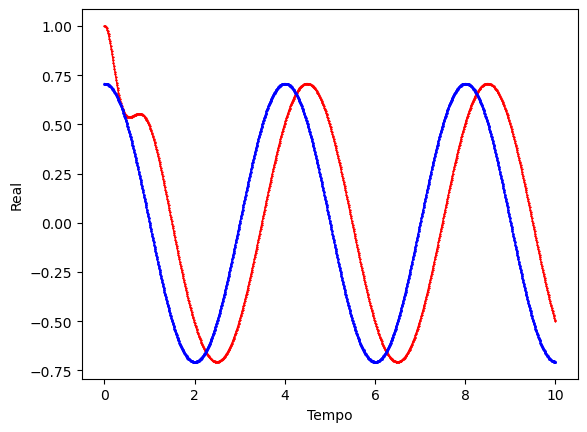

In [4]:
ts = np.linspace(0, 10, 1000)

x = [ele.real for ele in Resp[0]] 
y = [ele.imag for ele in Resp[0]] 

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, x, color='r', marker='*', linewidth=1, markersize=1)

p = []

for i in range(0, 1000):
    p.append(1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))

r = [ele.real for ele in p]
s = [ele.imag for ele in p]

plt.plot(ts, r, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo1.png', format='png')
plt.show()

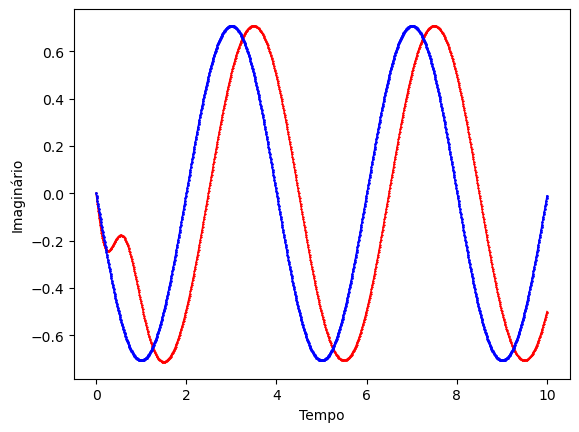

In [5]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, y, color='r', marker='*', linewidth=1, markersize=1)

plt.plot(ts, s, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo2.png', format='png')
plt.show()

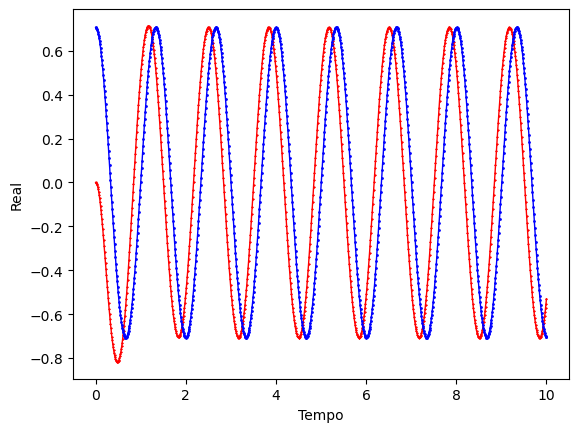

In [6]:
ts = np.linspace(0, 10, 1000)

x = [ele.real for ele in Resp[1]] 
y = [ele.imag for ele in Resp[1]] 

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, x, color='r', marker='*', linewidth=1, markersize=1)

p = []

for i in range(0, 1000):
    p.append(1/np.sqrt(2)*np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100))
    
r = [ele.real for ele in p]
s = [ele.imag for ele in p]

plt.plot(ts, r, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo3.png', format='png')
plt.show()

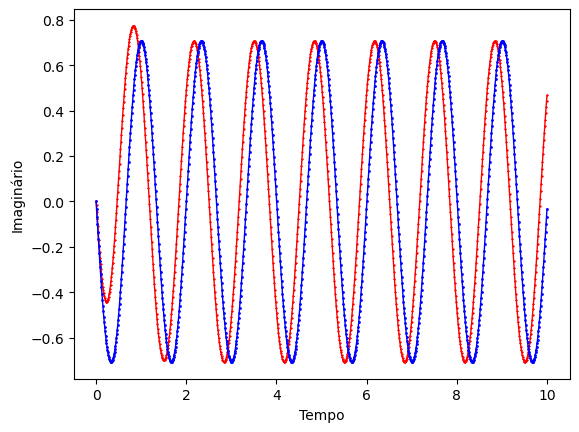

In [7]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, y, color='r', marker='*', linewidth=1, markersize=1)

plt.plot(ts, s, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo4.png', format='png')
plt.show()